# PUF Counties Aggregate - Factor Analysis - HTE Cost

DeSYNPuf Counties Aggregate with Elixhauser Sums per User & RWJF Factor Rankings Dataset

In [153]:
%matplotlib inline
import seaborn as sb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sklearn.preprocessing as pre

The file contains aggregated Medicare data from 2008-2010 (DeSYNPuf Synthetic Public Use Files), and RWJF County Health Factors and Outcomes Ranking Data from 2010.

1042 out of 3010 counties will be analyzed.  67 counties with outlying cost will be removed.

The 3010 was initially reduced to 2909 by removing a few outliers, removing counties not ranked by the County Health Rankings, and removing counties with zero users.

Then, the 2909 counties were subjected to a GLM gamma regression risk adjustment model, and the 1109 counties with higher than predicted cost were subsetted for this analysis.

67 of those counties had costs > 200000 per beneficiary and these were irreperably skewing the model results

The hope is to find factors behind the statistically significant variables that explain their higher than predicted costs, without ruining the model with extreme values

In [157]:
medicare_counties = pd.read_csv("/home/kylier/python/DS/data/PUF/HIGHER_THAN_PREDICTED.csv")
medicare_counties.shape


(1109, 73)

In [158]:
medicare_counties.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1109 entries, 0 to 1108
Data columns (total 73 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   FIPS_STATE_CODE             1109 non-null   int64  
 1   FIPS_COUNTY_CODE            1109 non-null   int64  
 2   CNTY_BENE_CT                1109 non-null   int64  
 3   CNTY_BENE_USRS              1109 non-null   int64  
 4   CNTY_MEAN_AGE               1109 non-null   float64
 5   CNTY_SEX_PROP               1109 non-null   float64
 6   TOT_CNCR_CASES              1109 non-null   int64  
 7   TOT_STRKETIA_CASES          1109 non-null   int64  
 8   TOT_ESRD_CASES              1109 non-null   int64  
 9   CNTY_TOT_VSTS               1109 non-null   int64  
 10  CNTY_TOT_IP_VSTS            1109 non-null   int64  
 11  CNTY_TOT_OP_VSTS            1109 non-null   int64  
 12  CNTY_TOT_CODES              1109 non-null   float64
 13  CNTY_TOT_PROCS              1109 

In [159]:
medicare_counties = medicare_counties[medicare_counties["TOT_COST_PB"]<200000]
medicare_counties.shape

(1042, 73)

In [160]:

medicare_counties["SR_TOT_IPDAYS"] = np.sqrt(medicare_counties["TOT_IPDAYS_PU"])
medicare_counties["SR_TOT_COST_PB"] = np.sqrt(medicare_counties["TOT_COST_PB"])

## Factor Analysis

The purpose of this notebook is to search for Latent Explanatory "Super Variables" or Factors within the data set.

Are there larger, underlying concepts that group together the important variables in the analysis in terms of their covariance?  Exploratory Factor Analysis is the way to investigate this.

In [161]:
from factor_analyzer import FactorAnalyzer

Prepare for Factor Analysis by subsetting to potentially significant variables, and dropping NULLs.

In [175]:
analysis_ds = medicare_counties[["CNTY_USR_PROP", "TOT_ESRD_PREV", "TOT_CVRG_MOS_PB_PY", "TOT_RXCVRG_MOS_PB_PY",
                                 "TOT_IP_VSTS_PU", "TOT_OP_VSTS_PU", "CODES_PU", "PROCS_PU", "PRVDRS_PU", 
                                 "SR_TOT_IPDAYS", "TOT_CC_PREV", "TOT_CC_INCD", "TOT_ELIX_PU", "SR_TOT_COST_PB", 
                                 "HO_PROP_RANK", "HF_PROP_RANK", "DIVERSE_PROP"]]

analysis_ds = analysis_ds.dropna()
analysis_ds.shape


(1042, 17)

In [176]:
analysis_ds

,CNTY_USR_PROP,TOT_ESRD_PREV,TOT_CVRG_MOS_PB_PY,TOT_RXCVRG_MOS_PB_PY,TOT_IP_VSTS_PU,TOT_OP_VSTS_PU,CODES_PU,PROCS_PU,PRVDRS_PU,SR_TOT_IPDAYS,TOT_CC_PREV,TOT_CC_INCD,TOT_ELIX_PU,SR_TOT_COST_PB,HO_PROP_RANK,HF_PROP_RANK,DIVERSE_PROP
1,0.500000,0.500000,12.000000,11.500000,1.000000,20.000000,20.666667,25.666667,2.000000,2.828427,2.500000,0.500000,0.766667,356.749212,0.714,0.804,0.000000
2,1.000000,0.000000,12.000000,12.000000,0.000000,38.000000,28.333333,39.333333,6.000000,0.000000,4.000000,1.000000,1.088889,301.214209,0.102,0.707,1.000000
4,1.000000,0.000000,12.000000,12.000000,0.000000,33.000000,32.666667,59.000000,5.333333,0.000000,8.000000,4.000000,1.304040,370.378185,0.768,0.848,0.000000
5,0.200000,0.200000,8.000000,4.466667,1.000000,21.000000,18.666667,25.000000,3.000000,4.000000,0.800000,0.600000,0.270833,169.344619,0.263,0.232,0.200000
8,1.000000,0.000000,12.000000,4.000000,1.000000,0.000000,3.333333,0.000000,0.333333,3.741657,2.000000,1.000000,2.000000,232.163735,0.797,0.766,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1104,0.784884,0.207849,11.327035,8.674903,0.861111,8.877778,10.747531,11.537654,2.361111,2.168802,4.363372,1.968023,1.574086,265.166764,0.012,0.000,0.136628
1105,0.823856,0.226075,11.581831,9.207120,0.840067,9.989899,11.555556,12.408530,2.270202,2.075186,4.744799,2.108183,1.518030,278.738942,0.065,0.177,0.209431
1106,0.730724,0.167260,11.606959,9.408066,0.676948,8.418831,9.672890,10.780303,1.976461,1.896682,3.725979,1.648873,1.477294,237.230116,0.732,0.661,0.277580
1107,0.845650,0.216925,11.441498,8.836313,0.895701,9.404510,11.268499,12.334390,2.885953,2.284550,4.718117,2.057807,1.641940,284.804140,0.198,0.416,0.178188


## Bartlett Test for Sphericity

A significant result (low p-value) indicates that a Factor Analysis may be appropriate.

In [177]:
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
chi_square_value,p_value=calculate_bartlett_sphericity(analysis_ds)
chi_square_value, p_value

(10155.948358655076, 0.0)

## Kaiser-Meyer-Olkin (KMO) Test 

This test measures the suitability of the specific variables in the data set, and the model as a whole, for factor analysis. 

It estimates the *proportion of variance* among all the observed variables. 

A lower proportion is more suitable for factor analysis. 

The KMO test values range between 0 and 1. **Value less than 0.6 are considered inadequate**.

In [178]:
from factor_analyzer.factor_analyzer import calculate_kmo
kmo_all,kmo_model=calculate_kmo(analysis_ds)
kmo_model

/home/kylier/anaconda3/lib/python3.8/site-packages/factor_analyzer/utils.py:248: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn('The inverse of the variance-covariance matrix '


0.7411196416062275

In [179]:
kmo_all

array([0.74400379, 0.83855302, 0.78980644, 0.81001394, 0.58851085,
       0.67698238, 0.6612116 , 0.8022826 , 0.93193382, 0.82587016,
       0.7875203 , 0.86000086, 0.88611759, 0.90714778, 0.49436621,
       0.4954526 , 0.68060737])

### These results indicate that some of the variables are inadequate.

Specifically, variable 5, variable 15 and 16.

The other variables are adequate (>.6).  

To remove variables based on the results of the KMO test, we should drop the **lowest value** variable first and re-run the test - removing only one variable at a time.

In [180]:
analysis_ds = analysis_ds.drop("HO_PROP_RANK", axis=1)
kmo_all,kmo_model=calculate_kmo(analysis_ds)
kmo_model

0.7621060325544592

In [181]:
kmo_all

array([0.74421696, 0.84078018, 0.78930321, 0.8125489 , 0.58837289,
       0.67793057, 0.66091185, 0.80224837, 0.93261485, 0.82631962,
       0.78763782, 0.85974473, 0.88453054, 0.90868598, 0.30600947,
       0.67917839])

Now we remove HF_PROP_RANK.

In [182]:
analysis_ds = analysis_ds.drop("HF_PROP_RANK", axis=1)
kmo_all,kmo_model=calculate_kmo(analysis_ds)
kmo_model

0.7627120442476829

In [183]:
kmo_all

array([0.74462295, 0.84141826, 0.78930864, 0.81285761, 0.58791473,
       0.67804017, 0.66070147, 0.80218927, 0.93447938, 0.82715846,
       0.78770803, 0.86022668, 0.88630012, 0.91051429, 0.67924886])

The final variable to remove is TOT_IP_VSTS_PU

In [184]:
analysis_ds = analysis_ds.drop("TOT_IP_VSTS_PU", axis=1)
kmo_all,kmo_model=calculate_kmo(analysis_ds)
kmo_model


0.7712187796932749

In [185]:
kmo_all

array([0.71533449, 0.92488223, 0.79624359, 0.80843521, 0.69414355,
       0.68921005, 0.85952553, 0.92796031, 0.53962168, 0.77805664,
       0.85363576, 0.79311699, 0.86711689, 0.63907677])

In [186]:
analysis_ds.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1042 entries, 1 to 1108
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   CNTY_USR_PROP         1042 non-null   float64
 1   TOT_ESRD_PREV         1042 non-null   float64
 2   TOT_CVRG_MOS_PB_PY    1042 non-null   float64
 3   TOT_RXCVRG_MOS_PB_PY  1042 non-null   float64
 4   TOT_OP_VSTS_PU        1042 non-null   float64
 5   CODES_PU              1042 non-null   float64
 6   PROCS_PU              1042 non-null   float64
 7   PRVDRS_PU             1042 non-null   float64
 8   SR_TOT_IPDAYS         1042 non-null   float64
 9   TOT_CC_PREV           1042 non-null   float64
 10  TOT_CC_INCD           1042 non-null   float64
 11  TOT_ELIX_PU           1042 non-null   float64
 12  SR_TOT_COST_PB        1042 non-null   float64
 13  DIVERSE_PROP          1042 non-null   float64
dtypes: float64(14)
memory usage: 122.1 KB


The final 14 variables look good, and the overall score is good (but not over 80, like the prior analysis).

Now, we can attempt the factor analysis on these Counties with Higher Than Predicted Cost.

This time, our most meritorious variable is... PRVDRS_PU!  Second is TOT_ESRD_PREV. 

### The final list of variables to be analyzed:

CNTY_USR_PROP
Proportion of users in the county with >0 claims during the period.

TOT_ESRD_PREV
Total prevalence of ESRD in the County (ESRD Cases / Total # of Beneficiaries)

TOT_CVRG_MOS_PB_PY  
The average number of months each beneficiary was covered by Medicare for each year

TOT_RXCVRG_MOS_PB_PY  
The average number of months each beneficiary was covered by Medicare Part D (the RX drug benefit) for each year

TOT_OP_VSTS_PU
The total # of outpatient visits per user

CODES_PU      
The Number of Codes per User (A User is a beneficiary with >0 claims for the period (2008-2010))

PROCS_PU      
The Number of Procedures per User (based on HCPCS Level 1 Codes)

PRVDRS_PU     
The Number of Providers per User

SR_IPDAYS_PU 
The Square Root of the Total Number of Inpatient Days per User (for Normalization)

TOT_CC_PREV   
The Total Number of Chronic Conditions / The Number of Beneficiaries in the County

TOT_CC_INCD   
The Total Number of NEW Chronic Conditions / The Number of Beneficiaries in the County

TOT_ELIX_PU   
The Sum of all the Avg Elixhauser Scores for all the Users in the County / # of Users 
The Elixhauser Score is a measure of a probable shortened lifespan / fragile health, above and beyond having or not having chronic conditions.

SR_TOT_COST_PB   
The Square Root of the Total Cost / Number of Beneficiaries in the County (for Normalization)

DIVERSE_PROP
The proportion of persons in the county who self-identify as not white.


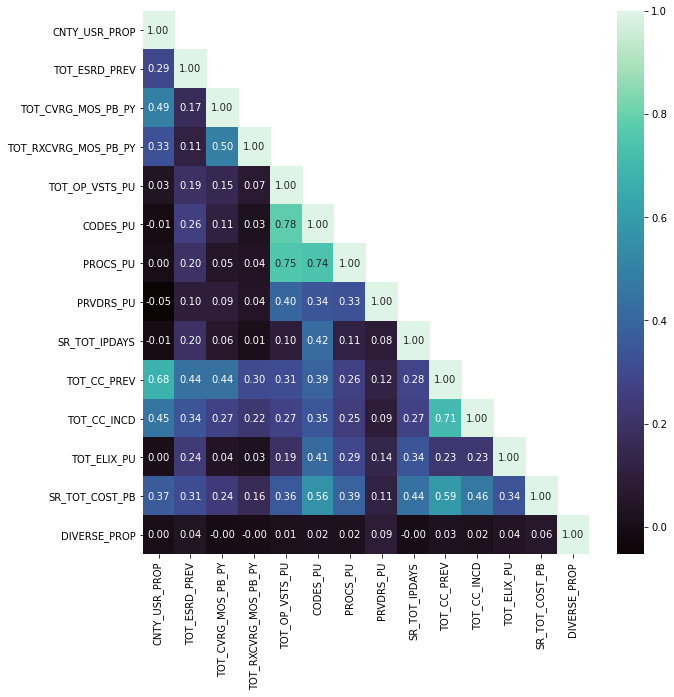

In [187]:
analysis_corr = analysis_ds.corr(method="spearman")
lower_corr = analysis_corr.where(np.tril(np.ones(analysis_corr.shape)).astype(np.bool))

plt.rcParams["figure.figsize"] = (10.0, 10.0)
analysis_hmap=sb.heatmap(lower_corr, annot=True, cmap="mako", fmt=".2f")
fig = analysis_hmap.get_figure()

fig.savefig("factor_analysis_heatmap.png")

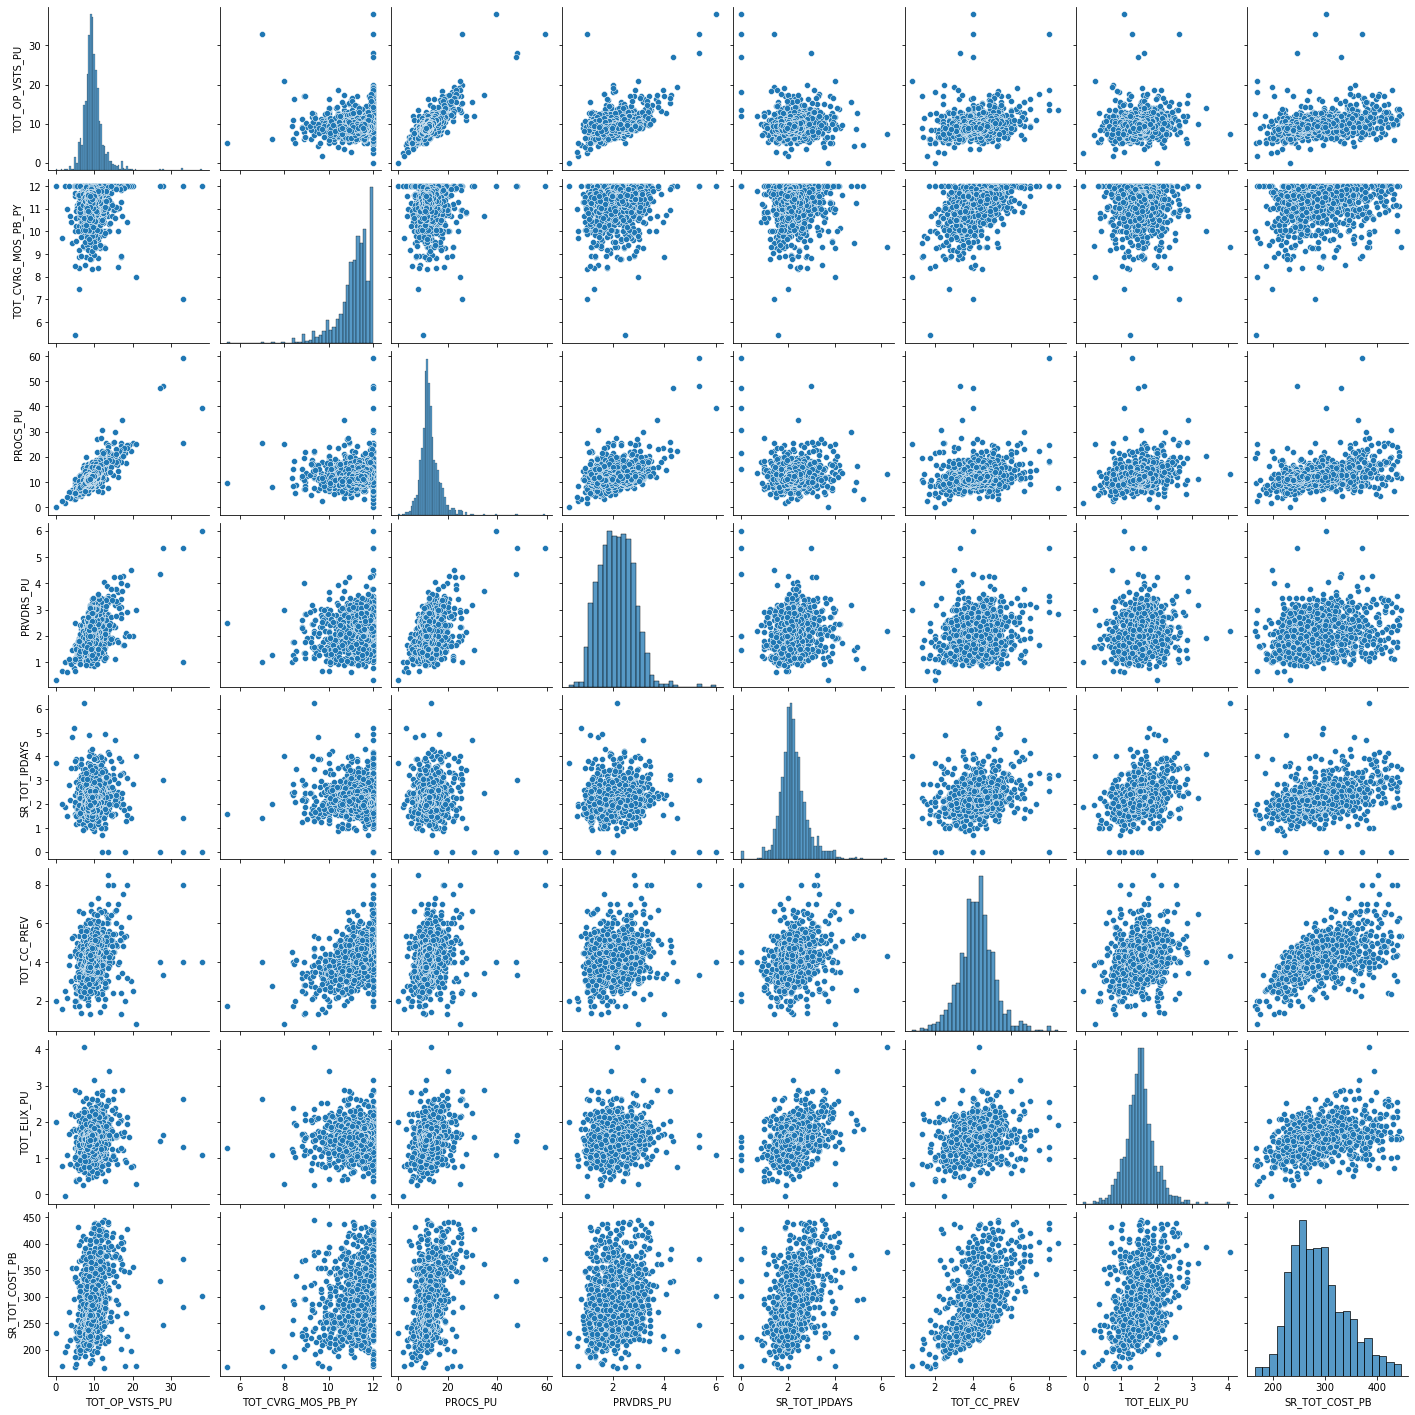

In [189]:
subset1 = analysis_ds[["TOT_OP_VSTS_PU", "TOT_CVRG_MOS_PB_PY", "PROCS_PU", "PRVDRS_PU", "SR_TOT_IPDAYS", 
                       "TOT_CC_PREV", "TOT_ELIX_PU", "SR_TOT_COST_PB"]]

sb.pairplot(subset1)

In [190]:
# Save a copy before transforming to an np.array

analysis_ds_copy = analysis_ds.copy()

## Standardize the Data

In [191]:
s = pre.StandardScaler()
analysis_ds = s.fit_transform(analysis_ds)

## Kaiser Criterion & Scree Plot

Examining Eigenvalues to determine the number of observable factors (Latent variables).

In [192]:
# Create factor analysis object and perform factor analysis
fa = FactorAnalyzer(rotation=None)
fa.fit(analysis_ds)

# Check Eigenvalues
ev, v = fa.get_eigenvalues()
ev

array([4.22801382, 2.58982249, 1.59150011, 0.98825297, 0.88929285,
       0.77415897, 0.67826788, 0.59522296, 0.52072277, 0.44541325,
       0.29796534, 0.18099948, 0.15120636, 0.06916075])

There are only 3 eigenvalues > 1.

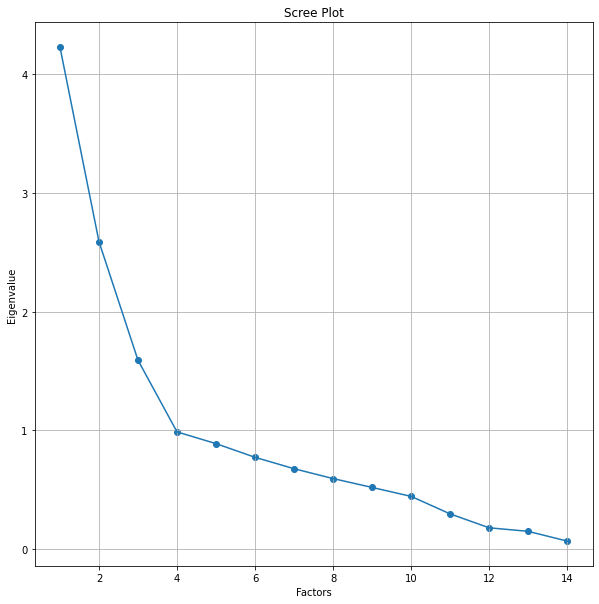

In [193]:
# Create scree plot 
plt.scatter(range(1,analysis_ds.shape[1]+1),ev)
plt.plot(range(1,analysis_ds.shape[1]+1),ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

In [194]:
fa = FactorAnalyzer(rotation="varimax", n_factors=3)
fa.fit(analysis_ds)
fa.loadings_

array([[-0.09091028,  0.85574565, -0.00341591],
       [ 0.05294383,  0.34254114,  0.28482488],
       [ 0.04759165,  0.62937415, -0.04647158],
       [ 0.04199613,  0.52915459, -0.06533185],
       [ 0.950233  ,  0.0882416 ,  0.05875741],
       [ 0.83748058, -0.00729939,  0.52102575],
       [ 0.85711453,  0.03328656,  0.17542342],
       [ 0.49558686,  0.0468954 ,  0.05436777],
       [-0.09068457, -0.02981351,  0.7080362 ],
       [ 0.16162462,  0.80850719,  0.42309015],
       [ 0.12601716,  0.56461799,  0.41093383],
       [ 0.14560885,  0.00133067,  0.5281384 ],
       [ 0.24337414,  0.39011268,  0.58352684],
       [ 0.1264362 ,  0.01091043, -0.0196384 ]])

In [195]:
analysis_ds_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1042 entries, 1 to 1108
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   CNTY_USR_PROP         1042 non-null   float64
 1   TOT_ESRD_PREV         1042 non-null   float64
 2   TOT_CVRG_MOS_PB_PY    1042 non-null   float64
 3   TOT_RXCVRG_MOS_PB_PY  1042 non-null   float64
 4   TOT_OP_VSTS_PU        1042 non-null   float64
 5   CODES_PU              1042 non-null   float64
 6   PROCS_PU              1042 non-null   float64
 7   PRVDRS_PU             1042 non-null   float64
 8   SR_TOT_IPDAYS         1042 non-null   float64
 9   TOT_CC_PREV           1042 non-null   float64
 10  TOT_CC_INCD           1042 non-null   float64
 11  TOT_ELIX_PU           1042 non-null   float64
 12  SR_TOT_COST_PB        1042 non-null   float64
 13  DIVERSE_PROP          1042 non-null   float64
dtypes: float64(14)
memory usage: 122.1 KB


## Loadings Analysis

**Factor 1** has the highest loadings on TOTAL_OP_VSTS, CODES, PROCS, PRVDRS.  It has low loadings on CC_PREV, CC_INCD and ELIX_PU.  It has very low or negative loadings on USR_PROP, ESRD_PREV, CVRG_MOS, RXCVRG_MOS, and IPDAYS.  It has the highest relationship to DIVERSE_PROP at 0.126, and is associated with 0.243 of COST.

**Factor 2** has the highest loadings on CNTY_USR_PROP, CC_PREV and high loadings on ESRD_PREV, CVRG_MOS and RX_CVRG_MOS and CC_INCD.  It has very low or negative loadings on TOT_OP_VSTS, CODES, PROCS, PRVDRS, and ELIX_PU. It is associated with 0.39 of COST.

**Factor 3** has the highest loadings on IPDAYS and ELIX_PU.  It has moderately high loadings on ESRD_PREV, CODES, CC_PREV, CC_INCD. It has low loadings on PROCS and very low or negative loadings on USR_PROP, CVRG_MOS, RXCVRG_MOS, OP_VSTS, PRVDRS and DIVERSE_PROP.

In [196]:
fa.get_communalities()

array([0.74057697, 0.20126269, 0.40053639, 0.28603651, 0.91418177,
       0.97289483, 0.76652668, 0.25076137, 0.5104278 , 0.85881167,
       0.50354041, 0.30013388, 0.55192245, 0.01649082])

## Communality

The amount of these variables' variance explained by their loading on the factors.

Highest explained: USR_PROP, OP_VSTS, CODES, PROCS and COST.

In [197]:
fa.get_factor_variance()

(array([2.74631004, 2.66257339, 1.8652208 ]),
 array([0.196165  , 0.19018381, 0.13323006]),
 array([0.196165  , 0.38634882, 0.51957887]))

## Factor Variance

First array: Sum of squared loadings (total factor variance)

Second array: Proportional variance of that factor vs. other factors

Third array: Cumulative variance of all factors (from left to right)


The **First Factor** is the most significant, the **Second Factor** is also very significant, and the **Third Factor** is somewhat less significant in explaining the total variance.

The three factors together account for approximately **51%** of the total variance in these variables.

In [198]:
fa.get_uniquenesses()

array([0.25942303, 0.79873731, 0.59946361, 0.71396349, 0.08581823,
       0.02710517, 0.23347332, 0.74923863, 0.4895722 , 0.14118833,
       0.49645959, 0.69986612, 0.44807755, 0.98350918])

## Uniquenesses

These are variances associated with only a specific varible.

The variables with highest uniqueness of variation are ESRD_PREV, RXCVRG_MOS, PRVDRS, ELIX_PU and DIVERSE_PROP.

This suggests these variables "are what they are" and that while they may be influential, they are not easily influenced.

## Can We Describe the Latent Variables / Factors?

## It isn't as simple this time. But let me try... 

**Factor 1 is our High Utilization Factor.**  It explains / groups counties by Total Visits, Number of Codes, Number of Procedures, and Number of Providers.  **This time it explains some of the cost for these higher-than-predicted counties, but it explains a moderate amount rather than the lion's share.** Can we call this "overutilization" now?  Maybe, but it might be an over-generalization to do so.  There's utilization in Factor 3 dominant counties, but because of their loadings we can conclude that it is more likely they needed those procedures and hospitalizations.  With this group?  Possibly not as much.

**Factor 2 is our Illness / Primary Care Factor.** It explains / groups counties by sickness: ESRD Prevalence, Chronic Condition Prevalence and Incidence, but NOT Severity of Illness.  It is associated with USR_PROP, Coverage Months, and a moderate amount of Cost. This looks like **diagnosed people who are seeing a provider**.

**Factor 3 is still our Hospitalization Factor.**  But again, things have become more complicated.  (Like the real world?) It explains / groups counties by the Length of IP Stays, has a moderately high association with ESRD Prevalence (sick people who often need hospitalization), CODES_PU, and a very high association with ELIX_PU (again, sicker people). **It has moderate association with Chronic Conditions prevalence and incidence, but low/mod association with Procedures. It has the highest factor loading for cost (0.58). Regardless of reason, hospitalizations are expensive!!** It also has very low or negative associations for Coverage Mos and # of Providers.  This is interesting, as it suggests the power of preventative care - if people are covered and seeing the provider (Factor 2), we know that hospitalizations become less frequent. It also suggests there may be areas where there are few PCPs but there are still hospitals.  In these areas (which might have low HF or HO Ranks) you don't go to the doctor, you just go directly to the hospital in a crisis (and stay a while).


In [199]:
# Reducing the data set based on the three factors 

df_reduced = fa.fit_transform(analysis_ds)
df_reduced

array([[ 3.64639973, -1.41261498, -0.55001851],
       [ 9.50436037,  1.16072395, -4.62659154],
       [ 8.8801499 ,  2.67008201, -0.6720766 ],
       ...,
       [-0.38842949, -0.07126291, -0.73307478],
       [-0.15952868,  0.5988662 , -0.03470528],
       [-0.23651565, -0.11211595, -0.74185485]])

In [200]:
FACTORS = pd.DataFrame(df_reduced, columns =["FACTORS_1", "FACTORS_2", "FACTORS_3"])


In [201]:
medicare_counties.shape

(1042, 75)

In [202]:
merged = medicare_counties.merge(FACTORS, left_index=True, right_index=True)

In [203]:
merged

,FIPS_STATE_CODE,FIPS_COUNTY_CODE,CNTY_BENE_CT,CNTY_BENE_USRS,CNTY_MEAN_AGE,CNTY_SEX_PROP,TOT_CNCR_CASES,TOT_STRKETIA_CASES,TOT_ESRD_CASES,CNTY_TOT_VSTS,...,TOT_COST_PB Predicted,Lower 95% Mean TOT_COST_PB,Upper 95% Mean TOT_COST_PB,Residuals,HIGHER_COST,SR_TOT_IPDAYS,SR_TOT_COST_PB,FACTORS_1,FACTORS_2,FACTORS_3
1,8,91,2,1,84.1,0.000000,0,0,1,21,...,30632.953957,28159.179606,33324.048543,96637.046043,1,2.828427,356.749212,9.504360,1.160724,-4.626592
2,13,125,1,1,63.9,0.000000,0,0,0,38,...,65798.998034,58030.622183,74607.301790,24931.001966,1,0.000000,301.214209,8.880150,2.670082,-0.672077
4,20,183,1,1,79.8,0.000000,0,0,0,33,...,125450.637750,115441.930670,136327.090350,11729.362246,1,0.000000,370.378185,-3.456731,-0.789089,-0.181167
5,20,185,5,1,78.4,0.400000,0,0,1,22,...,18394.559322,17077.254581,19813.478276,10283.040678,1,4.000000,169.344619,1.219228,-1.765491,-0.718831
8,22,75,1,1,82.0,0.000000,0,0,0,1,...,36795.483910,33896.571535,39942.317905,17104.516090,1,3.741657,232.163735,6.935231,-2.180662,-0.479794
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1037,42,129,174,137,73.9,0.402299,19,23,35,1421,...,55034.972194,52863.569674,57295.566362,10872.096772,1,2.096225,256.723721,-0.318701,0.222772,-0.149460
1038,47,93,181,140,71.6,0.497238,19,19,33,1318,...,56715.870937,54082.248355,59477.742032,4989.178786,1,2.189259,248.405011,0.020954,0.619065,-0.168292
1039,18,89,180,150,73.6,0.500000,22,20,37,1360,...,54105.338904,51479.360162,56865.269669,13633.061096,1,2.326657,260.266018,-0.388429,-0.071263,-0.733075
1040,48,215,174,151,73.3,0.419540,30,24,49,1662,...,70528.707530,67275.623606,73939.092932,15691.637297,1,2.321794,293.633010,-0.159529,0.598866,-0.034705


## Discover & Record the Dominant Factor for Each County

In [204]:
HIGH_F1 = merged[(merged["FACTORS_1"]>merged["FACTORS_2"]) & (merged["FACTORS_1"] > merged["FACTORS_3"])]
HIGH_F2 = merged[(merged["FACTORS_2"]>merged["FACTORS_1"]) & (merged["FACTORS_2"] > merged["FACTORS_3"])]
HIGH_F3 = merged[(merged["FACTORS_3"]>merged["FACTORS_1"]) & (merged["FACTORS_3"] > merged["FACTORS_2"])]

f1_rows = HIGH_F1.index.values
f2_rows = HIGH_F2.index.values
f3_rows = HIGH_F3.index.values

for f in f1_rows:
    merged.at[f,"D_FACTOR"] = 1

for f in f2_rows:
    merged.at[f, "D_FACTOR"] = 2

for f in f3_rows:
    merged.at[f, "D_FACTOR"] = 3

In [205]:
merged

,FIPS_STATE_CODE,FIPS_COUNTY_CODE,CNTY_BENE_CT,CNTY_BENE_USRS,CNTY_MEAN_AGE,CNTY_SEX_PROP,TOT_CNCR_CASES,TOT_STRKETIA_CASES,TOT_ESRD_CASES,CNTY_TOT_VSTS,...,Lower 95% Mean TOT_COST_PB,Upper 95% Mean TOT_COST_PB,Residuals,HIGHER_COST,SR_TOT_IPDAYS,SR_TOT_COST_PB,FACTORS_1,FACTORS_2,FACTORS_3,D_FACTOR
1,8,91,2,1,84.1,0.000000,0,0,1,21,...,28159.179606,33324.048543,96637.046043,1,2.828427,356.749212,9.504360,1.160724,-4.626592,1.0
2,13,125,1,1,63.9,0.000000,0,0,0,38,...,58030.622183,74607.301790,24931.001966,1,0.000000,301.214209,8.880150,2.670082,-0.672077,1.0
4,20,183,1,1,79.8,0.000000,0,0,0,33,...,115441.930670,136327.090350,11729.362246,1,0.000000,370.378185,-3.456731,-0.789089,-0.181167,3.0
5,20,185,5,1,78.4,0.400000,0,0,1,22,...,17077.254581,19813.478276,10283.040678,1,4.000000,169.344619,1.219228,-1.765491,-0.718831,1.0
8,22,75,1,1,82.0,0.000000,0,0,0,1,...,33896.571535,39942.317905,17104.516090,1,3.741657,232.163735,6.935231,-2.180662,-0.479794,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1037,42,129,174,137,73.9,0.402299,19,23,35,1421,...,52863.569674,57295.566362,10872.096772,1,2.096225,256.723721,-0.318701,0.222772,-0.149460,2.0
1038,47,93,181,140,71.6,0.497238,19,19,33,1318,...,54082.248355,59477.742032,4989.178786,1,2.189259,248.405011,0.020954,0.619065,-0.168292,2.0
1039,18,89,180,150,73.6,0.500000,22,20,37,1360,...,51479.360162,56865.269669,13633.061096,1,2.326657,260.266018,-0.388429,-0.071263,-0.733075,2.0
1040,48,215,174,151,73.3,0.419540,30,24,49,1662,...,67275.623606,73939.092932,15691.637297,1,2.321794,293.633010,-0.159529,0.598866,-0.034705,2.0


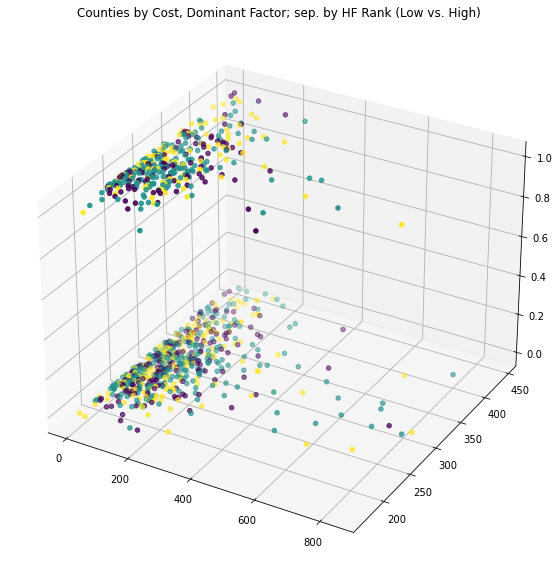

In [210]:
m_subset = merged.copy()

from mpl_toolkits import mplot3d

fig = plt.figure()
ax = plt.axes(projection='3d')
z = m_subset["HF_HIGH"]
y = m_subset["SR_TOT_COST_PB"]
x = m_subset["FIPS_COUNTY_CODE"]
c = m_subset["D_FACTOR"]
ax.scatter(x, y, z, c=c)
ax.set_title('Counties by Cost, Dominant Factor; sep. by HF Rank (Low vs. High)')
plt.show()

## Note

I played around with this graph and did find that there were a **smaller number** of counties with HF_HIGH=1 with Factor 1 and Factor 3 dominance.  

## Highest Cost by Dominant Factor

Of the top 20 highest cost counties in this data set (outliers are removed here), 

7 out of 20 have Factor 1 dominance

8 have Factor 2 dominance

and 5 have Factor 3 dominance

Some have negative values for all 3 factors, suggesting there are definitely **other things that still account for cost**; it is never as simple as 3 factors.

In [212]:
# Highest Cost / ALL

hc = merged[["STATE", "COUNTY", "D_FACTOR", "FACTORS_1", "FACTORS_2", "FACTORS_3", "DIVERSE_PROP", "HF_PROP_RANK", "HO_PROP_RANK", 
                 "TOT_CC_PREV", "TOT_ELIX_PU", "PROCS_PU", "PRVDRS_PU", "TOT_IPDAYS_PU", "TOT_COST_PB"]]

hc.sort_values(by="TOT_COST_PB", ascending=False).head(20)

,STATE,COUNTY,D_FACTOR,FACTORS_1,FACTORS_2,FACTORS_3,DIVERSE_PROP,HF_PROP_RANK,HO_PROP_RANK,TOT_CC_PREV,TOT_ELIX_PU,PROCS_PU,PRVDRS_PU,TOT_IPDAYS_PU,TOT_COST_PB
33,Kansas,Barber,1.0,0.408324,0.032729,-1.436269,0.000000,0.667,0.747,5.333333,1.556548,11.666667,3.000000,12.000000,198352.66667
248,Oklahoma,Major,1.0,-0.171150,-1.175599,-0.716816,0.000000,0.987,0.675,6.285714,1.522363,22.055556,2.666667,8.500000,195182.57143
455,Oklahoma,Osage,2.0,-0.864000,0.883030,-0.059032,0.000000,0.403,0.740,5.333333,1.742806,20.181818,2.393939,3.909091,195140.16667
239,Montana,Fergus,2.0,-1.521603,0.125698,-0.913908,0.000000,0.568,0.864,4.875000,1.596142,12.777778,2.222222,9.833333,192211.75000
32,Iowa,Ringgold,2.0,1.951832,2.710692,0.842959,0.000000,0.505,0.657,8.000000,2.558730,18.333333,3.500000,6.500000,191897.00000
92,Montana,Carbon,1.0,0.838139,-3.017964,-0.179103,0.000000,0.727,0.955,3.000000,2.136251,24.111111,1.777778,7.333333,191784.00000
336,Mississippi,Walthall,3.0,-0.214663,-1.235546,0.078344,0.000000,0.420,0.593,6.125000,2.301149,11.833333,1.583333,12.875000,191101.50000
279,Kansas,Ford,2.0,-0.744852,1.142062,0.457303,0.000000,0.525,0.869,4.375000,1.026443,13.333333,2.619048,5.000000,190845.75000
575,Georgia,Bulloch,3.0,0.144620,0.852106,0.953121,0.368421,0.701,0.758,4.315789,1.517427,13.187500,3.104167,7.625000,189265.26316
411,Missouri,Clinton,3.0,-0.488264,-1.595985,0.116308,0.083333,0.748,0.800,3.333333,0.715741,6.633333,1.133333,3.500000,186406.50000


In [213]:
factor1_df = merged[merged["D_FACTOR"] == 1]
factor2_df = merged[merged["D_FACTOR"] == 2]
factor3_df = merged[merged["D_FACTOR"] == 3]

## Top 10 Factor 1 Dominant Counties by Cost (Descending)

NOTE: There is a mix of factor 1 and 3 dominance in this list. 
Again, there are fair number with smallish #s across the board.

In [215]:
uc = factor1_df[["STATE", "COUNTY", "FACTORS_1", "FACTORS_2", "FACTORS_3", "DIVERSE_PROP", "HF_PROP_RANK", "HO_PROP_RANK", 
                 "TOT_CC_PREV", "TOT_ELIX_PU", "PROCS_PU", "PRVDRS_PU", "TOT_IPDAYS_PU", "TOT_COST_PB"]]

uc.sort_values(by="TOT_COST_PB", ascending=False).head(10)

,STATE,COUNTY,FACTORS_1,FACTORS_2,FACTORS_3,DIVERSE_PROP,HF_PROP_RANK,HO_PROP_RANK,TOT_CC_PREV,TOT_ELIX_PU,PROCS_PU,PRVDRS_PU,TOT_IPDAYS_PU,TOT_COST_PB
33,Kansas,Barber,0.408324,0.032729,-1.436269,0.000000,0.667,0.747,5.333333,1.556548,11.666667,3.000000,12.000000,198352.66667
248,Oklahoma,Major,-0.171150,-1.175599,-0.716816,0.000000,0.987,0.675,6.285714,1.522363,22.055556,2.666667,8.500000,195182.57143
92,Montana,Carbon,0.838139,-3.017964,-0.179103,0.000000,0.727,0.955,3.000000,2.136251,24.111111,1.777778,7.333333,191784.00000
631,Illinois,Woodford,0.778568,0.640242,-1.545782,0.260870,0.950,0.970,4.608696,2.143196,16.879630,2.361111,8.388889,184292.43478
113,Vermont,Grand Isle,2.357585,1.635414,-0.154461,0.000000,0.357,0.643,8.000000,2.127405,24.777778,2.888889,9.666667,183375.33333
703,Maine,Hancock,0.375708,0.245328,-0.854835,0.000000,0.500,0.875,5.071429,2.444655,17.833333,3.378788,9.500000,177310.64286
162,Texas,San Saba,1.192121,0.908498,0.549955,0.000000,0.471,0.869,7.000000,2.585795,11.833333,1.916667,17.250000,176579.00000
194,Oklahoma,Pushmataha,2.268665,0.263491,1.087389,0.125000,0.026,0.208,5.125000,1.692421,24.266667,3.400000,14.600000,169705.00000
89,Missouri,Pike,-1.183863,-1.613371,-1.241299,0.000000,0.530,0.235,6.250000,1.451058,16.888889,2.444444,17.666667,162116.00000
384,Washington,San Juan,0.914374,-0.053875,0.504968,0.111111,0.974,0.974,4.222222,1.724551,17.185185,1.555556,5.555556,160729.77778


## Top 10 Factor 2 Dominant Counties by Cost (Descending)


In [217]:
ic = factor2_df[["STATE", "COUNTY", "FACTORS_1", "FACTORS_2", "FACTORS_3", "DIVERSE_PROP", "HF_PROP_RANK", "HO_PROP_RANK", 
                 "TOT_CC_PREV", "TOT_ELIX_PU", "PROCS_PU", "PRVDRS_PU", "TOT_IPDAYS_PU", "TOT_COST_PB"]]

ic.sort_values(by="TOT_COST_PB", ascending=False).head(10)

,STATE,COUNTY,FACTORS_1,FACTORS_2,FACTORS_3,DIVERSE_PROP,HF_PROP_RANK,HO_PROP_RANK,TOT_CC_PREV,TOT_ELIX_PU,PROCS_PU,PRVDRS_PU,TOT_IPDAYS_PU,TOT_COST_PB
455,Oklahoma,Osage,-0.864000,0.883030,-0.059032,0.000000,0.403,0.740,5.333333,1.742806,20.181818,2.393939,3.909091,195140.16667
239,Montana,Fergus,-1.521603,0.125698,-0.913908,0.000000,0.568,0.864,4.875000,1.596142,12.777778,2.222222,9.833333,192211.75000
32,Iowa,Ringgold,1.951832,2.710692,0.842959,0.000000,0.505,0.657,8.000000,2.558730,18.333333,3.500000,6.500000,191897.00000
279,Kansas,Ford,-0.744852,1.142062,0.457303,0.000000,0.525,0.869,4.375000,1.026443,13.333333,2.619048,5.000000,190845.75000
400,Kentucky,Perry,-0.618029,1.742727,-0.271762,0.071429,0.133,0.033,4.285714,1.932037,16.266667,1.766667,3.500000,185009.00000
109,Texas,Kinney,0.133922,0.198897,-0.695739,0.333333,0.615,0.475,2.333333,1.572222,30.555556,1.444444,0.000000,182183.33333
808,Missouri,Cass,0.231356,1.012527,0.645698,0.111111,0.887,0.913,5.333333,1.538183,15.258065,2.139785,9.193548,181573.16667
324,Indiana,Jennings,-0.124972,1.065321,-0.790451,0.111111,0.043,0.109,5.555556,1.724504,19.416667,1.416667,8.000000,179129.33333
35,Kentucky,Livingston,1.237052,1.627851,-3.351893,0.500000,0.450,0.492,6.500000,2.166667,25.500000,1.833333,5.000000,170027.00000
685,West Virginia,Ohio,-0.105140,0.495549,0.187173,0.038462,0.873,0.764,4.846154,1.734905,18.516667,3.350000,7.350000,169689.53846


## Top 10 Factor 3 Dominant Counties by Cost (Descending)


In [219]:
hoc = factor3_df[["STATE", "COUNTY", "FACTORS_1", "FACTORS_2", "FACTORS_3", "DIVERSE_PROP", "HF_PROP_RANK", "HO_PROP_RANK", 
                 "TOT_CC_PREV", "TOT_ELIX_PU", "PROCS_PU", "PRVDRS_PU", "TOT_IPDAYS_PU", "TOT_COST_PB"]]

hoc.sort_values(by="TOT_COST_PB", ascending=False).head(10)

,STATE,COUNTY,FACTORS_1,FACTORS_2,FACTORS_3,DIVERSE_PROP,HF_PROP_RANK,HO_PROP_RANK,TOT_CC_PREV,TOT_ELIX_PU,PROCS_PU,PRVDRS_PU,TOT_IPDAYS_PU,TOT_COST_PB
336,Mississippi,Walthall,-0.214663,-1.235546,0.078344,0.000000,0.420,0.593,6.125000,2.301149,11.833333,1.583333,12.875000,191101.50000
575,Georgia,Bulloch,0.144620,0.852106,0.953121,0.368421,0.701,0.758,4.315789,1.517427,13.187500,3.104167,7.625000,189265.26316
411,Missouri,Clinton,-0.488264,-1.595985,0.116308,0.083333,0.748,0.800,3.333333,0.715741,6.633333,1.133333,3.500000,186406.50000
231,Kentucky,Jackson,0.633797,0.221957,0.689494,0.000000,0.025,0.192,5.000000,2.472156,20.000000,3.250000,13.166667,182308.50000
155,Pennsylvania,Sullivan,0.123391,-0.176194,0.598988,0.250000,0.134,0.433,6.500000,0.991041,11.333333,1.166667,7.250000,181555.00000
45,Nevada,Lincoln,-0.843740,-1.444839,4.441868,0.400000,0.733,0.267,2.400000,2.640351,25.500000,2.333333,12.500000,175910.80000
152,North Dakota,Nelson,-0.582579,-2.024706,1.096735,0.000000,0.295,0.659,4.800000,2.205787,11.416667,2.250000,9.500000,173566.80000
818,South Carolina,Orangeburg,-0.079828,0.460243,0.973555,0.292683,0.304,0.109,4.536585,1.891646,18.088542,3.135417,9.718750,173027.70732
278,Kansas,Dickinson,0.686995,0.387102,1.632017,0.000000,0.434,0.727,4.777778,1.888875,17.666667,3.000000,4.428571,172615.11111
128,Iowa,Lyon,-2.011620,-0.821304,0.519186,0.200000,0.929,0.960,4.000000,2.574134,8.666667,1.583333,12.000000,171784.00000


# The Highest Cost Counties...

May be dominant in one of the three Factors, but they often have a mix of factors playing a role.

They also retain some unexplained variance.

In [220]:
merged["D_FACTOR"].value_counts()

2.0    451
3.0    267
1.0    257
Name: D_FACTOR, dtype: int64

## Highest 10 Factor 1 Counties

**"Here, I can do this procedure and fix that for you." (Hopefully, it helps.)**

Count with HF_HIGH: 5

Mean CC Prevalence: 3.35

Mean CC Incidence: 1

Mean Elix PU: 1.1

Mean # Procedures PU: **15.3**

Mean # Providers PU: **2.4**

Mean # of OP Visits PB: **13.9**

Mean # IP Days PU: 4.9

Total Cost PB: **$692,401.77**


In [235]:
highest_f1 = merged[(merged["D_FACTOR"] == 1) & (merged["FACTORS_1"] > 2.8)]

hf1 = highest_f1[["STATE", "COUNTY", "FACTORS_1", "FACTORS_2", "FACTORS_3", "DIVERSE_PROP", "HF_PROP_RANK", "HO_PROP_RANK", 
                 "TOT_CC_PREV", "TOT_ELIX_PU", "PROCS_PU", "PRVDRS_PU", "TOT_IPDAYS_PU", "TOT_COST_PB"]]

hf1.sort_values(by="TOT_COST_PB", ascending=False).head(10)

,STATE,COUNTY,FACTORS_1,FACTORS_2,FACTORS_3,DIVERSE_PROP,HF_PROP_RANK,HO_PROP_RANK,TOT_CC_PREV,TOT_ELIX_PU,PROCS_PU,PRVDRS_PU,TOT_IPDAYS_PU,TOT_COST_PB
1,Colorado,Ouray,9.504360,1.160724,-4.626592,0.0,0.804,0.714,2.50,0.766667,25.666667,2.000000,8.000000,127270.000000
93,Montana,Jefferson,2.833516,2.380504,2.657610,0.0,0.932,0.705,3.25,1.232407,11.888889,3.666667,5.333333,102383.000000
2,Georgia,Glascock,8.880150,2.670082,-0.672077,1.0,0.707,0.102,4.00,1.088889,39.333333,6.000000,0.000000,90730.000000
15,South Dakota,Jackson,6.935381,0.963488,-2.922868,0.0,0.105,0.105,5.00,1.000000,6.000000,2.000000,5.000000,73542.000000
16,Tennessee,Bledsoe,3.674236,-1.574511,-1.280775,0.0,0.253,0.842,6.00,0.583333,13.333333,2.000000,4.000000,69312.000000
8,Louisiana,Plaquemines,6.935231,-2.180662,-0.479794,0.0,0.766,0.797,2.00,2.000000,0.000000,0.333333,14.000000,53900.000000
94,Montana,Powell,3.616284,-1.639737,-0.031218,0.0,0.273,0.295,2.00,0.968254,8.333333,0.666667,3.666667,49059.500000
13,Oklahoma,Jefferson,7.763252,-3.268449,2.277528,0.0,0.377,0.117,3.00,1.571429,18.000000,2.000000,3.000000,47686.000000
21,Alabama,Bullock,2.935944,-3.007423,0.654585,0.2,0.075,0.060,3.00,0.760913,22.500000,4.500000,2.000000,39327.600000
213,Colorado,Teller,3.372777,-1.907418,1.201721,0.0,0.696,0.375,2.75,1.081019,8.000000,1.277778,4.000000,39191.666667


## Highest 10 Factor 2 Counties

**"We're getting what we need." (Sometimes it's expensive.)**

Count with HF_HIGH: 5

These counties had higher average numbers of coverage months for both MC and RX than the other factor groups.

Mean CC Prevalence: **5.5**

Mean CC Incidence: **2.9**

Mean Elix PU: 1.36

Mean # Procedures PU: 13.2

Mean # Providers PU: 2.3

Mean # OP Vists PU: 11

Mean # IP Days PU: 5.3

Total Cost PB: **$940,511.80**

In [256]:
highest_f2 = merged[(merged["D_FACTOR"] == 2) & (merged["FACTORS_2"] > 1.88)]

hf2 = highest_f2[["STATE", "COUNTY", "FACTORS_1", "FACTORS_2", "FACTORS_3", "DIVERSE_PROP", "HF_PROP_RANK", "HO_PROP_RANK", 
                 "TOT_CC_PREV", "TOT_CC_INCD", "TOT_ELIX_PU", "PROCS_PU", "PRVDRS_PU", "TOT_IPDAYS_PU", "TOT_COST_PB"]]

hf2.sort_values(by="TOT_COST_PB", ascending=False).head(10)

,STATE,COUNTY,FACTORS_1,FACTORS_2,FACTORS_3,DIVERSE_PROP,HF_PROP_RANK,HO_PROP_RANK,TOT_CC_PREV,TOT_CC_INCD,TOT_ELIX_PU,PROCS_PU,PRVDRS_PU,TOT_IPDAYS_PU,TOT_COST_PB
32,Iowa,Ringgold,1.951832,2.710692,0.842959,0.000000,0.505,0.657,8.000000,4.500000,2.558730,18.333333,3.500000,6.500000,191897.000000
28,Georgia,Baker,-0.285665,2.391259,0.953711,0.000000,0.134,0.535,8.000000,4.000000,0.979630,18.166667,3.333333,10.500000,151524.000000
82,Louisiana,Tensas,-1.435499,2.111328,0.574296,0.333333,0.141,0.875,7.000000,5.000000,1.753608,9.333333,2.666667,10.333333,135364.666670
459,Texas,Erath,-1.089300,1.912856,1.141459,0.416667,0.855,0.946,6.166667,3.000000,0.781176,12.484848,2.515152,2.727273,89127.500000
68,Georgia,Randolph,-0.732270,2.126238,2.104775,0.666667,0.127,0.025,5.333333,3.333333,0.893967,17.666667,2.111111,1.666667,72774.000000
237,Missouri,Mississippi,-0.736149,2.004522,1.025184,0.000000,0.035,0.061,5.333333,2.500000,1.676543,12.555556,1.944444,3.666667,70894.333333
222,Illinois,De Witt,1.165980,2.425999,0.758853,0.166667,0.663,0.178,4.833333,2.000000,0.835380,16.833333,1.833333,4.333333,70000.333333
147,Nebraska,Polk,0.446149,2.083899,0.930672,0.166667,0.667,0.427,3.500000,1.666667,2.256944,10.250000,1.666667,7.750000,63974.333333
83,Massachusetts,Nantucket,0.476583,1.880322,1.690903,0.000000,0.714,0.929,4.750000,2.500000,0.598846,8.777778,2.555556,3.666667,60170.000000
301,Ohio,Champaign,0.071826,2.842677,0.402416,0.000000,0.659,0.580,2.545455,0.727273,1.243254,7.571429,1.333333,2.285714,34785.636364



## Highest 10 Factor 3 Counties

**"Everything is fine, until it's not." (And it is costing us!)**

Count with HF_HIGH: 5

Mean CC Prevalence: 4

Mean CC Incidence: 1.9

Mean Elix PU: 1.6

Mean # Procedures PU: 15.8

Mean # Providers PU: 2.4

Mean # OP Visits PU: 11.6

Mean # IP Days PU: **6.7**

Total Cost PB: **$1,120,318.18**

In [280]:
highest_f3 = merged[(merged["D_FACTOR"] == 3) & (merged["FACTORS_3"] > 2.9)]

hf3 = highest_f3[["STATE", "COUNTY", "FACTORS_1", "FACTORS_2", "FACTORS_3", "DIVERSE_PROP", "HF_PROP_RANK", "HO_PROP_RANK", 
                 "TOT_CC_PREV", "TOT_CC_INCD", "TOT_ELIX_PU", "TOT_VSTS_PB", "PROCS_PU", "PRVDRS_PU", "TOT_IPDAYS_PU", "TOT_COST_PB"]]

hf3.sort_values(by="TOT_COST_PB", ascending=False).head(10)

,STATE,COUNTY,FACTORS_1,FACTORS_2,FACTORS_3,DIVERSE_PROP,HF_PROP_RANK,HO_PROP_RANK,TOT_CC_PREV,TOT_CC_INCD,TOT_ELIX_PU,TOT_VSTS_PB,PROCS_PU,PRVDRS_PU,TOT_IPDAYS_PU,TOT_COST_PB
45,Nevada,Lincoln,-0.843740,-1.444839,4.441868,0.400000,0.733,0.267,2.400000,1.200000,2.640351,7.000000,25.500000,2.333333,12.500000,175910.800000
39,Mississippi,Wilkinson,0.704730,2.700803,3.392567,0.000000,0.407,0.160,7.500000,4.500000,1.210979,19.000000,22.166667,1.666667,11.000000,162865.000000
84,Minnesota,Clearwater,-1.911540,-0.547602,4.006699,0.000000,0.024,0.529,3.750000,2.000000,1.770899,9.000000,14.888889,2.222222,12.666667,155511.500000
212,California,Inyo,2.616033,-2.004681,3.021922,0.333333,0.643,0.107,6.166667,2.833333,1.668210,10.666667,11.555556,2.055556,6.333333,138176.333330
191,Oklahoma,Beckham,0.971685,-0.088289,3.007229,0.500000,0.701,0.143,4.375000,3.125000,2.006109,9.750000,20.533333,3.400000,7.400000,118271.750000
60,Alabama,Coosa,0.078606,-2.240428,3.061178,0.375000,0.239,0.254,3.375000,0.875000,1.179233,5.750000,14.944444,4.055556,5.666667,93613.250000
211,Arkansas,Phillips,0.758175,0.473616,3.968771,0.111111,0.000,0.000,2.555556,1.111111,1.582209,5.555556,12.527778,2.444444,4.833333,77252.222222
18,Texas,Carson,2.503247,0.067394,4.028830,0.500000,0.946,0.692,4.000000,2.000000,1.083333,7.000000,14.000000,2.333333,3.000000,76526.000000
120,Florida,Holmes,-1.186548,-0.278555,3.181278,0.200000,0.194,0.090,2.800000,0.400000,1.508333,5.600000,7.166667,1.666667,2.250000,62838.000000
22,Alaska,Sitka,1.834885,2.282503,3.310875,0.333333,0.909,0.909,3.333333,1.666667,1.812500,7.000000,14.166667,1.500000,1.000000,59353.333333


In [281]:
merged.to_csv("/home/kylier/python/DS/data/PUF/HIGHER_THAN_PREDICTED_FACTORS.csv")